[29545.10437784  2480.38660651]
[  2813.13110094 399137.2623216 ]


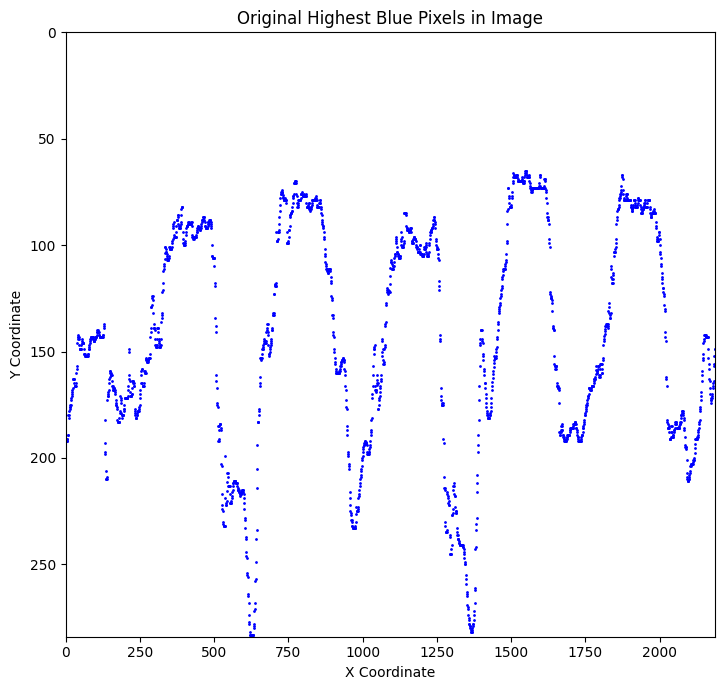

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd, eigh

def extract_highest_blue_pixels(image_path):
    # Load the image
    image = Image.open(image_path)
    
    # Convert image to RGB mode if it's not already
    image = image.convert('RGB')
    
    # Get the image size
    width, height = image.size
    
    # Initialize a dictionary to hold the highest y-coordinate blue pixel for each x-coordinate
    highest_blue_pixels = {x: None for x in range(width)}
    
    # Define the range for inclusive blue colors
    def is_inclusive_blue(r, g, b):
        return b > 100 and b > r + 20 and b > g + 20
    
    # Iterate over each pixel in the image
    for x in range(width):
        for y in range(height):
            r, g, b = image.getpixel((x, y))
            if is_inclusive_blue(r, g, b):
                if highest_blue_pixels[x] is None or y > highest_blue_pixels[x]:
                    highest_blue_pixels[x] = y
    
    return highest_blue_pixels, width, height

def interpolate_missing_points(highest_blue_pixels, width, height):
    x_coords = list(highest_blue_pixels.keys())
    y_coords = [highest_blue_pixels[x] for x in x_coords]
    
    # Find indices where y_coords are not None
    valid_indices = [i for i, y in enumerate(y_coords) if y is not None]
    invalid_indices = [i for i, y in enumerate(y_coords) if y is None]
    
    # Perform linear interpolation for missing values
    if valid_indices:
        valid_x = [x_coords[i] for i in valid_indices]
        valid_y = [y_coords[i] for i in valid_indices]
        
        # Use numpy to interpolate
        interpolated_y = np.interp(invalid_indices, valid_x, valid_y)
        
        # Fill the missing y_coords with interpolated values
        for idx, y in zip(invalid_indices, interpolated_y):
            y_coords[idx] = y
    
    return np.array(x_coords), np.array(y_coords)

def plot_highest_blue_pixels(image_path):
    highest_blue_pixels, width, height = extract_highest_blue_pixels(image_path)
    x_coords, y_coords = interpolate_missing_points(highest_blue_pixels, width, height)
    
    data_matrix = np.vstack((x_coords, y_coords)).T
    
    data_mean = np.mean(data_matrix, axis=0)
    centered_data = data_matrix - data_mean
    
    # Perform SVD
    data_matrix = np.vstack((x_coords, y_coords)).T
    U, s, VT = np.linalg.svd(data_matrix - np.mean(data_matrix, axis=0), full_matrices=False)
    
    print(s)
    
    covariance_matrix = np.cov(centered_data.T)
    eigenvalues, _ = eigh(covariance_matrix)
    
    print(eigenvalues)
    
    # Project data onto principal components
    SVD_components = np.dot(data_matrix - np.mean(data_matrix, axis=0), VT.T)
    
    # Plot the original and SVD-transformed data
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.scatter(x_coords, y_coords, c='blue', s=1)
    plt.title('Original Highest Blue Pixels in Image')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().invert_yaxis()  # Invert the y-axis to have the highest points at the top

    # plt.subplot(1, 2, 2)
    # plt.scatter(SVD_components[:, 0], SVD_components[:, 1], c='red', s=1)
    # plt.title('SVD Transformed Coordinates')
    # plt.xlabel('First Principal Component')
    # plt.ylabel('Second Principal Component')
    
    plt.tight_layout()
    plt.show()

# Example usage
image_path = 'blueyellow.png'
plot_highest_blue_pixels(image_path)

In [34]:
highest_blue_pixels, width, height = extract_highest_blue_pixels(image_path)
x_coords, y_coords = interpolate_missing_points(highest_blue_pixels, width, height)
print(y_coords)

[191. 191. 191. ... 152. 149. 149.]


Singular Values:
 [1.31044428e+05 3.39852325e+04 3.16788942e+04 9.36523422e+03
 6.37034961e+03 6.34135798e+03 5.90481546e+03 5.33311873e+03
 4.94697784e+03 4.78094818e+03 4.67898817e+03 4.28551327e+03
 3.92975090e+03 3.21906519e+03 3.13464326e+03 2.86780034e+03
 2.86650287e+03 2.63113656e+03 2.29438766e+03 2.24295157e+03
 2.21772818e+03 1.56885587e+03 1.49002281e+03 1.40067220e+03
 1.14149155e+03 1.04176879e+03 9.90606847e+02 9.52229115e+02
 8.49881891e+02 8.36985134e+02 8.31410080e+02 7.74992218e+02
 7.72380193e+02 7.24161971e+02 7.22584200e+02 7.19388987e+02
 6.93459090e+02 6.83489086e+02 6.60025656e+02 6.52517899e+02
 6.42210332e+02 6.33286823e+02 6.31676238e+02 6.18591041e+02
 6.16487765e+02 5.98356155e+02 5.95528662e+02 5.79407356e+02
 5.74633308e+02 5.67017232e+02 5.50599986e+02 5.21727800e+02
 5.08556749e+02 5.01331948e+02 4.75168627e+02 4.67921407e+02
 4.50985427e+02 4.30288780e+02 4.25993628e+02 4.25743177e+02
 4.10290349e+02 3.95168088e+02 3.88122288e+02 3.82852630e+02
 3.660

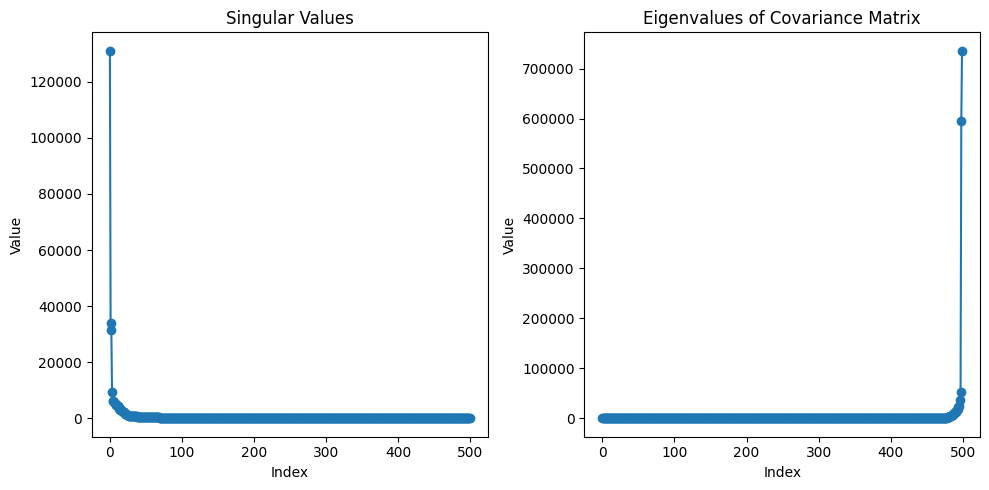

In [46]:
# Assume `time_series` is your 1D list of values
time_series = np.array(y_coords)  # replace with your actual data

# Parameters for time delay embedding
L = 500  # window length (embedding dimension)
N = len(time_series)
K = N - L + 1  # number of rows in the trajectory matrix

# Create the trajectory matrix
trajectory_matrix = np.zeros((K, L))
for i in range(K):
    trajectory_matrix[i] = time_series[i:i+L]

# Perform SVD
U, s, VT = svd(trajectory_matrix, full_matrices=False)

# Compute eigenvalues of the covariance matrix of the trajectory matrix
covariance_matrix = np.cov(trajectory_matrix, rowvar=False)
eigenvalues, _ = eigh(covariance_matrix)

# Display the singular values and eigenvalues
print("Singular Values:\n", s)
print("Eigenvalues:\n", eigenvalues)

# Plot the singular values and eigenvalues
plt.figure(figsize=(10, 5))

# Singular values
plt.subplot(1, 2, 1)
plt.plot(s, marker='o')
plt.title('Singular Values')
plt.xlabel('Index')
plt.ylabel('Value')

# Eigenvalues
plt.subplot(1, 2, 2)
plt.plot(eigenvalues, marker='o')
plt.title('Eigenvalues of Covariance Matrix')
plt.xlabel('Index')
plt.ylabel('Value')

plt.tight_layout()
plt.show()